# Attempting to predict the outcome of a hit baseball:

#### By: Joshua Helperin

Ah, baseball. The quintisential American sport where middle-aged men flock to the stadium to watch younger-aged men stand in a field and dugout doing nothing for 75% of the game. Even still, these people standing in the field get paid millions of dollars to do so. Why is that? Well, it makes sense if you're a pitcher. That position obviously takes some serious skill. According to https://www.usatoday.com/sports/mlb/salaries/2019/player/all/, pitchers (specifically starting pitchers) had 4 out of the top 5, 6 out of the top 10 spots, and 10 out of the top 16 spots for highest salaries in 2019. But if you're not a pitcher, then my assumption would be that you're being paid to hit the ball, and ideally, hit a home-run. This is also supported by glancing at the data sicne the other 3 spots in the top 10 salries were held by people famous for hitting a lot of home runs. So, what I would like to find out is if the amount of home runs that someone hits truly corresponds to the amount that they get paid, and whether or not it does correspond to a higher salary, what determines whether a hit ball will be a home run or not? This is important to determine since finding out what makes a hit ball a home run or not will be crucial to trainers and players when practicing, as it can help them focus and prioritize certain aspects of a swing.

## Part 1: Data Collection

Let's import the required libraries

In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

Luckily, the MLB have been taking detailed statistics for each and every player with their automated tool, Statscast, which was introduced in 2015. 

The Statscast glossary can be found at http://m.mlb.com/glossary/statcast/

All baseball players salaries from 2019 can be found at https://www.usatoday.com/sports/mlb/salaries/2019/player/all/.

In [2]:
# GET request
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.2 Safari/605.1.15'}

response = requests.get('https://www.usatoday.com/sports/mlb/salaries/2019/player/all/', headers=headers)

if response.status_code != 200:
    print(response)
    raise Exception

In [3]:
soup = BeautifulSoup(response.text, 'html5lib')
salary_table = soup.find('table')
salaries = pd.read_html(str(salary_table), flavor='bs4', parse_dates=True)[0]
salaries

,rank,Name,Team,POS,Salary,Years,Total Value,Avg Annual
0,--,Max Scherzer,WSH,SP,"$42,142,857",7 (2015-21),"$210,000,000","$30,000,000"
1,--,Stephen Strasburg,WSH,SP,"$36,428,571",7 (2017-23),"$175,000,000","$25,000,000"
2,--,Mike Trout,LAA,CF,"$34,083,333",6 (2015-20),"$144,500,000","$24,083,333"
3,--,Zack Greinke,ARI,SP,"$32,421,884",6 (2016-21),"$206,500,000","$34,416,667"
4,--,David Price,BOS,SP,"$31,000,000",7 (2016-22),"$217,000,000","$31,000,000"
...,...,...,...,...,...,...,...,...
872,--,Frank Schwindel,KC,1B,"$555,000",1 (2019),"$555,000","$555,000"
873,--,Nick Vincent,SF,RP,"$555,000",1 (2019),"$555,000","$555,000"
874,--,Rowdy Tellez,TOR,1B,"$555,000",1 (2019),"$555,000","$555,000"
875,--,Ildemaro Vargas,ARI,SS,"$555,000",1 (2019),"$555,000","$555,000"


The swing profiles of players during the regular season of 2019 can be found on and downloaded from https://baseballsavant.mlb.com/ through the search tab.

After receiving the full data, I deleted columns that were unnecessary from the perspective of the batter. (For example, I deleted statistics that were taken from the perspective of the catcher and pitcher.)

CSV header documentation can be found at https://baseballsavant.mlb.com/csv-docs. 

In [4]:
swings = pd.read_csv('swing_profiles.csv')
swings.head()

,release_speed,player_name,events,zone,stand,p_throws,plate_x,plate_z,hc_x,hc_y,...,ax,ay,az,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,launch_speed_angle,pitch_name
0,83.8,Yonathan Daza,single,2.0,R,R,0.15,3.64,122.81,191.82,...,0.940137,19.506878,-29.473577,NaN,NaN,83.8,1988.0,5.8,NaN,Slider
1,91.4,Dominic Smith,home_run,1.0,L,L,-0.31,3.16,216.49,38.44,...,11.268536,30.492854,-9.032454,97.3,26.0,90.8,2383.0,6.3,5.0,4-Seam Fastball
2,90.2,Wilson Ramos,single,7.0,R,R,-0.45,1.90,84.42,109.04,...,-17.421931,28.452432,-18.318783,103.1,-11.0,90.0,1985.0,6.4,2.0,2-Seam Fastball
3,96.4,Tyrone Taylor,double,4.0,R,R,-0.31,2.50,202.75,122.16,...,-11.144672,24.695154,-19.060711,75.1,20.0,97.9,2199.0,6.6,4.0,4-Seam Fastball
4,80.0,Mike Yastrzemski,single,6.0,L,R,0.46,2.43,92.48,106.94,...,5.236128,22.746067,-43.816530,75.4,23.0,78.8,2789.0,5.6,4.0,Knuckle Curve


## Part 2: Data Processing

Luckily, there's really not much to do because the data has been processed for us already. The rank column in the salaries table is missing (although we could just use the index + 1) and there are some missing values in the swing profile data, but that doesn't matter for now.

In [5]:
salaries['rank'] = salaries.index.copy() + 1
salaries['Salary'] = pd.Series([int(salary[1:].replace(',', '')) for salary in salaries['Salary']])

## Part 3: Exploratory Analysis and Data Visualiztion

Notice that the number of players that actually went up to bat are less than the number of players in the MLB. Therefore, we should only take into consideration the salaries of MLB players who went up to bat during the 2019 regular season.

In [6]:
print(f'# Actual Batters: {len(swings["player_name"].unique())}')
print(f'# MLB Players: {salaries.index[-1]}')

# Actual Batters: 760
# MLB Players: 876


Now, we can easily determine if there exists a positive relationship betwewen home-runs and salaries by plotting these stats against each other.

In [7]:
no_bat_players = 0
no_bat_players_arr = []

player_home_runs = []
player_salaries = []
player_names = []

for index, row in salaries.iterrows():
    player_swings = swings[swings['player_name'] == row['Name']]

    if player_swings.empty:
        no_bat_players += 1
        no_bat_players_arr.append(row['Name'])
    else:
        individual_HR = len(player_swings[player_swings['events'] == 'home_run'])
        if individual_HR != 0:
            player_home_runs.append(individual_HR)
            player_salaries.append(row['Salary'])
            player_names.append(row['Name'])

print(f'There were approximately {no_bat_players} MLB players who didn\'t see an at-bat in the regular season of 2019')


There were approximately 384 MLB players who didn't see an at-bat in the regular season of 2019


In [8]:
def get_pos_distrib_dict(player_list):
    pos_distribution = {}

    for player in player_list:
        player_pos = salaries[salaries['Name'] == player]['POS'].values[0]
        
        if player_pos not in pos_distribution:
            pos_distribution[player_pos] = 1
        else:
            pos_distribution[player_pos] += 1
    
    return pos_distribution

In [9]:
def make_bar_chart(x, y, height_y, step, xlabel='', ylabel='', title='', figsize=None):
    if len(x) != len(y) or height_y < 10:
        raise Exception('Invalid Parameters for make_bar_chart') 
    plt.figure(figsize=figsize)
    plt.bar(np.arange(len(x)), y, align='center')
    plt.xticks(np.arange(len(y)), x)
    plt.yticks(np.arange(height_y, step=step))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

{'SP': 105, 'OF': 6, 'RP': 254, '2B': 5, 'C': 1, '1B': 2, 'CF': 4, 'RF': 3, '3B': 2, 'SS': 2}


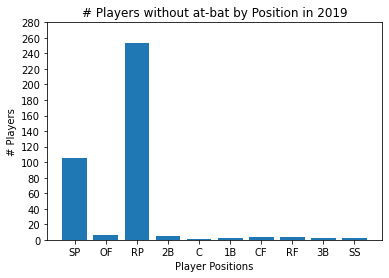

In [10]:
no_bat_player_pos_dict = get_pos_distrib_dict(no_bat_players_arr)

print(no_bat_player_pos_dict)

make_bar_chart(no_bat_player_pos_dict.keys(), no_bat_player_pos_dict.values(), 300, 20, 'Player Positions', '# Players', '# Players without at-bat by Position in 2019')

From this bar chart, we can see that most of the players who do not see an at-bat are starting and relief pitchers. This makes sense as a pitcher getting injured by, for example, getting hit with a ball while batting could cost them and the team the season. What's interesting to note is that the position that has the most players who do not see an at-bat are relief pitchers. I'm not sure why this is the case or why there are so many relief pitchers in the MLB in the first place.

Now, lets move on to trying to correlate the amount of home runs one acheives and their salary.

### Entity Resolution

In [11]:
home_run_hitters = swings[swings['events'] == 'home_run']['player_name'].unique()
print(f'# Home run hitters acc. to swing profile table: {len(home_run_hitters)}')
print(f'# Home run hitters present in salaries table: {len(player_home_runs)}')

# Home run hitters acc. to swing profile table: 543
# Home run hitters present in salaries table: 382


This is a problem. There are home run hitters that don't appear in the salaries table. Luckily, there are other datasets that can fill in the missing data. Even more so, what I noticed is that these players actually don't show up on the table I was considering to query at https://www.spotrac.com/mlb/rankings/2019/salary/ instead of the other table that I queried. Why is this? I have no idea. But these players do show up in the Base Salary table at https://www.spotrac.com/mlb/rankings/2019/base/. 

Now, of course, another problem occurs. Visiting this site overheats my computer because the site takes up too much memory, but more importantly, when I query the website and obtain the table, it only gives me the first 100 rows. (I think it's because the table is using JQuery's Datatables which are paginated by default, and then they using the JQuery Tablesort plugin to mess with the ordering and enabling the table to show all the rows even though it's "paginated.") 

Short story, the site is not helpful. Some of the players that are missing salary data don't exist in that table either. So, because not all tables on the internet have the salary data of these players, I'm not going to take them into account when making calculations.

More importantly, this is why I said approximately 384 MLB players did not see an at-bat since players don't exist in both tables. Nevertheless, the trend that pitchers do not see at-bats still holds.

Text(0, 0.5, 'Salary * 1e7')

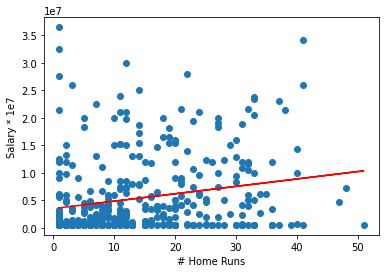

In [12]:
plt.scatter(player_home_runs, player_salaries)

# Trend line
m, b = np.polyfit(np.array(player_home_runs), np.array(player_salaries), 1)

plt.plot(pd.Series(player_home_runs), m * pd.Series(player_home_runs) + b, color='r')

plt.xlabel('# Home Runs')
plt.ylabel('Salary * 1e7')

We sort of expect the data to look like this. Hitting a home-run is a hard thing to do. It's rare for some players to hit one, and even impossible for others, so seeing a lot of people hitting between 1-20 homeruns and a fewer people hitting 20-50+ homeruns makes sense. What doesn't make sense on the other hand is why there are players hitting 30+ homeruns and being payed essentially the lowest base salary of the MLB. Obviously, there is some other factor that I'm not taking into consideration. Could the players position be a possible factor? Let's take the people who were in top 10% of salaries and check their positions.

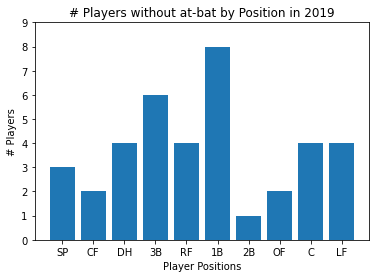

In [13]:
top_10_perc = round(len(player_names) * .1)

top_10_pos_dict = get_pos_distrib_dict(player_names[:top_10_perc])

make_bar_chart(top_10_pos_dict.keys(), top_10_pos_dict.values(), 10, 1, xlabel='Player Positions', ylabel='# Players', title='# Players without at-bat by Position in 2019')

Well, it doesn't seem like a single position dominates the top 10% of salaries to a significant extent. So, in the end, it doesn't seem like the number of home runs that one gets and their salary are actually correlated. But, as it turns out, other studies have found correlations between salaries and other performance measures besides home runs. Example: https://cardinalscholar.bsu.edu/bitstream/handle/123456789/201580/SchweringDavid-combined.pdf?sequence=1

### EDA Part 2

Some other things we can easily find out and look at are the distributions of homeruns with other aspects of the swing, like the zone the ball was hit in and the type of pitch thrown.

Baseball players, when at-bat, try their best to discern the zone that the ball will cross over. It helps them determine whether to "swing for the fence" or not. So, what zones are the best to try and hit a home-run?

In [14]:
def get_list_distributions(groups):
    categories = []
    distributions = []
    max_height = 0

    for group, data in groups:
        categories.append(group)
        distributions.append(len(data.index))
        max_height = max(max_height, len(data.index))
    
    return categories, distributions, max_height

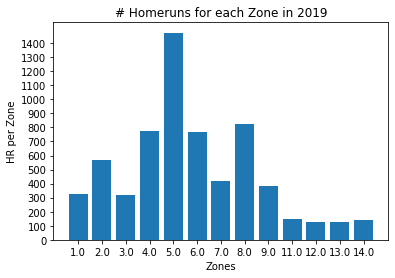

In [15]:
all_home_runs = swings[swings['events'] == 'home_run']

zone_groups = all_home_runs.groupby('zone')

zones, dist_zones, yheight = get_list_distributions(zone_groups)

make_bar_chart(zones, dist_zones, yheight+10, 100, xlabel='Zones', ylabel='HR per Zone', title='# Homeruns for each Zone in 2019')

This distribution also fits our implicit assumptions. The best/easiest time to hit a home run is when the ball crosses over zone 5 of the plate from the perspective of the catcher (i.e. the dead center of the strike zone) and the next 4 best zones create a cross within the middle of the strike zone such that the ball is in the middle with respect to the x or y axis of the strike zone.

![title](images/plate_zones.png)

Taken from baseballsavant.mlb.com

Batters also try to discern the type of pitch that is being thrown to them, again, in order to help determine whether they should swing or not.

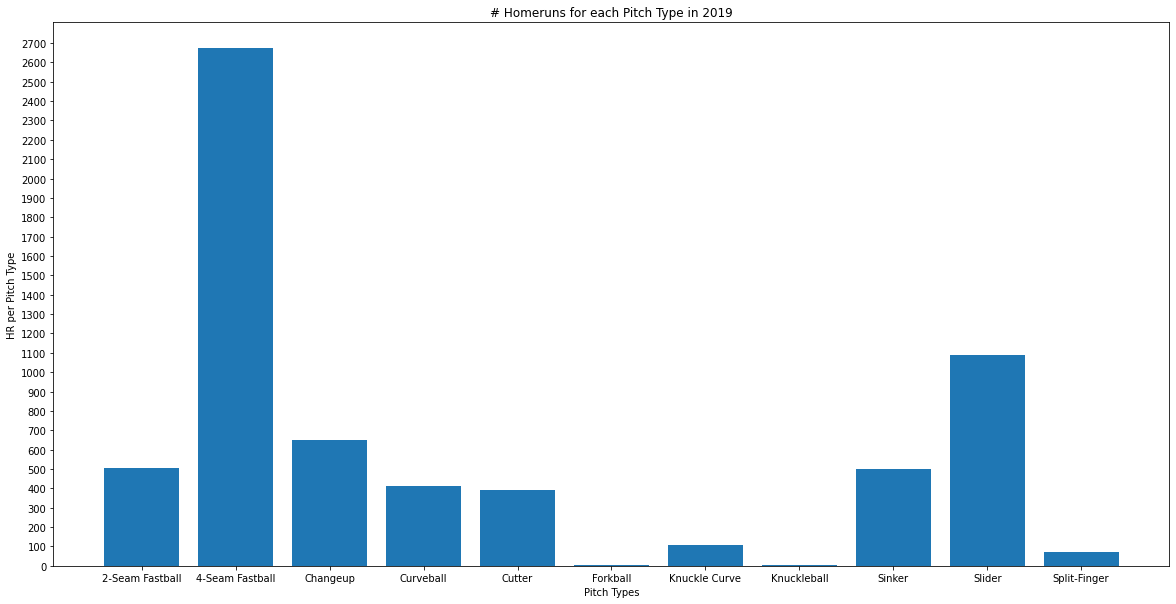

In [16]:
pitch_type_groups = all_home_runs.groupby('pitch_name')

pitch_types, dist_pitch_types, yheight = get_list_distributions(pitch_type_groups)

make_bar_chart(pitch_types, dist_pitch_types, yheight+100, 100, xlabel='Pitch Types', ylabel='HR per Pitch Type', title='# Homeruns for each Pitch Type in 2019', figsize=(20, 10))

To no surprise, the a fastball is the easiest pitch to hit a home run off of. Sliders having second place in this list is also not suprising, since the sliders tend to go towards zone 8, a good zone to hit a home run. Another reason sliders are good pitches to hit home runs is that the ball accelerates when it slides, and the faster the ball is as it hits the bat, the faster it goes off the bat (Newton's third law of motion). But, what in the world is the difference between a 2SF and a 4SF? I have no clue. I primarily played 3rd-base and catcher, so don't ask me. But let's find out.

The only difference (from my understanding) between a 2SF and a 4SF is the way the pitcher holds the ball (with two fingers and 4 fingers respectively). That must somehow change the way the ball is moving, because otherwise, why make the distinction between the two pitches and choose one over the other? Therefore, we should look at the speed and spin rate of each type of pitch to see if we can determine a significant difference.

In [17]:
from statistics import mean, stdev

SF2 = all_home_runs[all_home_runs['pitch_name'] == '2-Seam Fastball']
SF4 = all_home_runs[all_home_runs['pitch_name'] == '4-Seam Fastball']

SF2 = SF2.dropna()
SF4 = SF4.dropna()

mean_eff_speed_2SF = mean(SF2['effective_speed'])
mean_eff_speed_4SF = mean(SF4['effective_speed'])

std_eff_speed_2SF = stdev(SF2['effective_speed'])
std_eff_speed_4SF = stdev(SF4['effective_speed'])

mean_spin_rate_2SF = mean(SF2['release_spin_rate'])
mean_spin_rate_4SF = mean(SF4['release_spin_rate'])

std_spin_rate_2SF = stdev(SF2['release_spin_rate'])
std_spin_rate_4SF = stdev(SF4['release_spin_rate'])

print(f'Mean Effective Speed 2SF vs 4SF:\t {mean_eff_speed_2SF}  {mean_eff_speed_4SF}')
print(f'Stdev Effective Speed 2SF vs 4SF:\t {std_eff_speed_2SF}  {std_eff_speed_4SF}')
print(f'Mean Spin Rate 2SF vs 4SF:\t\t {mean_spin_rate_2SF}  {mean_spin_rate_4SF}')
print(f'Stdev Spin Rate 2SF vs 4SF:\t\t {std_spin_rate_2SF}  {std_spin_rate_4SF}')
print()
print(f'Number of 2SF thrown: {len(SF2.index)}')
print(f'Number of 4SF thrown: {len(SF4.index)}')

Mean Effective Speed 2SF vs 4SF:	 92.27459349593497  92.85297048677654
Stdev Effective Speed 2SF vs 4SF:	 2.9984016172025973  3.081056027053607
Mean Spin Rate 2SF vs 4SF:		 2168.701219512195  2279.15446531238
Stdev Spin Rate 2SF vs 4SF:		 169.27625428061535  180.60119092924333

Number of 2SF thrown: 492
Number of 4SF thrown: 2609


We see from here that there really isn't a significant difference between the two types of fastballs. The reason there were so many more homeruns hit with 4SFs were because there were more 4SFs thrown! What is intersting to note here is that the average spin rate for the 4SF is higher by 100 RPM (revolutions per minute), which actually can be significant when it comes to throwing a strike. At this point, I still didn't know why pithcer throw one kind of fastball over the other. I thought maybe it's personal preference or just the way the pitchers were trained. Turns out there is an actual strategy as to when to throw these two different pitches. You can read about it like I did over hear: https://baseballboom.com/4-seam-vs-2-seam-fastball/

## Part 4: Analysis, Hypothesis, Testing, and Machine Learning

Now that we've looked at the data and saw the distributions of home runs with specific aspects of the swing, let's now try to figure out whether these aspects are even significant when trying to hit a home run and try to predict whether a swing will be a home run or not. By finding this out, batters and trainers can focus on specific aspects to maximize their chances at hitting a home run.

So, how do we do we determine the significance of each aspect of the swing (i.e. feature)? Well, we can check the p-value of each feature when fitted on a model, and if the p-value is less < 0.5, we say that the feature is significant in explanining the result and otherwise not. The problem is that the p-values of the features change based on which features you fit. Therefore, we can only say that a single feature is insignificant in a model, since a model without this feature could make the rest of the insignificant features significant in the new model.

But how do we determine which feature to remove if there are multiple insignificant features? Obviously, we take out the feature that is the least significant, i.e. has the highest p-value in the model. From there we fit the remaining features and repeat this process of taking an insignificant feature out of the model and refitting the model on the rest of the features. This process is called Backwards Elimination. We could also do a similar process call Forward Selection that is like the reverse of this process, such that you choose one feature at a time and keep the feature if it and the rest of chosen features are significant after fitting the model. Ideally, I would like to use something akin to the ols_step_all_possible() method in the olsrr library in R, but from what I've seen, there's not such a method for all possible regresssions, backwards elimination, or forward selection in any Python library, so we're going to have to do this manually.

Instead of trying to do multinomial logistic regression due to having 4 classifications (single, double, triple, home_run), we will simplify the multinomial logistic regression into 4 binary logistic regression problems, each of which will determine whether a hit is a certain event or not for each event (i.e. single/other, double/other, etc.) Additonally, I drop some features when fitting the logit model due to internal linear algebra errors that occur as well as dummy categorical variables not being significant.

In [ ]:
from statsmodels.formula.api import logit
from functools import reduce

# Data Cleaning: 
# 
# ,  separate independent/dependent
# variables, dummify pitch_name, concat back together, add constant column. I am making an assumption that stance
# of batter/pitcher is not significant, hence I am dropping them.


# Pitch name dummy variables cause the overall resulting matrix
# after concatenation back to the original matrix to have a determinant
# of 0, which means it doesn't have an inverse (but it needs one to fit the model).

# Drop observations with NA
remaining_swings = swings.dropna()

remaining_swings['zone'] = 'Zone' + remaining_swings['zone'].astype(int).astype(str)
remaining_swings['launch_speed_angle'] = 'lsa_' + remaining_swings['launch_speed_angle'].astype(int).astype(str)

# Dummify categorical variable that we want to fit.
zone_dummies = pd.get_dummies(remaining_swings['zone'])
lsa_dummies = pd.get_dummies(remaining_swings['launch_speed_angle'])

# Concat dummies back
remaining_swings = pd.concat([remaining_swings, zone_dummies, lsa_dummies], axis=1)

# Drop features we don't want to fit, includin original categorical variables.
remaining_swings = remaining_swings.drop(['player_name', 'stand', 'p_throws', 'zone', 'launch_speed_angle', 'pitch_name'], axis=1)

features = list(remaining_swings.keys())

# Make events/dependent variable the last column and 
# remove dependent variable (event) from features as it's the outcome and we don't want it in the formula.
features.remove('events')
features.append('events')
remaining_swings = remaining_swings[features]
features.pop() # Removes events

# Remove 1 feature for each categorical variable since for
# every categorical variable, you should only fit n-1 dummies.
features.remove('Zone1')
features.remove('lsa_1')

# Used to change this column on every iteration.
event_strings = remaining_swings['events']

# Output features concatenated with '+' to be used in formula below.
def format_formula(features):
    return reduce(lambda f1, f2: f'{f1} + {f2}', features)

# Keep track of global similarities and cumulative features used in the end of every model.
union_of_features = set({})
intersection_of_features = set({})

# 4 logit models, 1 for each event
for event in ['single', 'double', 'triple', 'home_run']:

    # make output 1 if event is correct, make output 0 if incorrect
    remaining_swings['events'] = event_strings.map(lambda x: 1 if x == event else 0)

    # Want to reset the features to the full feature set for every event.
    temp_features = features.copy()
    
    # Tells us whether there was an insignificant feature that
    # we removed and therfore we need to refit the logit model
    flag = True

    # Backwards Elimination
    while flag:
        logit_mod = logit('events ~ ' + format_formula(temp_features), remaining_swings)
        logit_res = logit_mod.fit(disp=0)
        
        max_pVal = 0
        max_pVal_index = 0  # Corresponds to index in temp_features that point to feature w/ highest p-value.
        for index, p_val in enumerate(logit_res.pvalues[1:]): # Skip p_val for Intercept
            if p_val > max_pVal:
                max_pVal = p_val
                max_pVal_index = index
        
        # Check if feature with highest p-value is significant.
        if max_pVal > .05:
                temp_features.pop(max_pVal_index)
        else:
            # Use set operations to see which models have which features in 
            # common and obtain overall feature set for all models.
            if intersection_of_features == set({}):
                intersection_of_features |= set(logit_res.model.exog_names)
            else:
                intersection_of_features &= set(logit_res.model.exog_names)
            union_of_features |= set(logit_res.model.exog_names)

            # Print summary of model obtained for event.
            print(f'\n\nFor event = {event}:\n\n{logit_res.summary()}\n\n')

            flag = False

union_of_features.remove('Intercept')
intersection_of_features.remove('Intercept')

print(f'Union: {union_of_features.sort()}\n')
print(f'Intersection: {intersection_of_features.sort()}')

Well, other than that we can say that our models are pretty terrible since they have very low R-Squared values and the fact that some of our models do not converge the maximum likelihood estimator, so there's not much else to say. Notably, the R-Squared value for the home_run model was significantly higher the other R-Squared values, possibly becuase their is a bigger difference between home runs and the other types of hits (need more power, etc.). Although, one thing we can say is that there is few common significant features between the models.

Let's move onto a different model, one that can hopefully predict the outcome of a swing. Let's try K-Nearest Neighbors.

Best average prediction score for k-NN with 10-fold CV is: 0.9691569994960486 with 18 neighbors


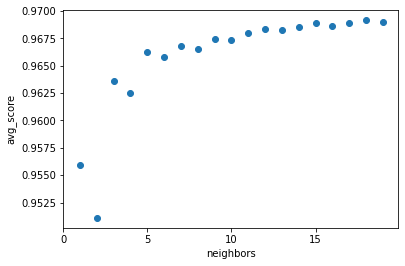

In [23]:
# k-NN Classifier with 10-fold cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

significant_features = remaining_swings[sorted(list(union_of_features))]
significant_features['events'] = remaining_swings['events']

X = significant_features.iloc[:, :-1]
y = significant_features['events']

knn_avg_scores = []
neighbors = []

knn_max_avg_score = 0
best_n = 1

for n in range(1, 20):
    neigh = KNeighborsClassifier(n_neighbors=n)

    knn_cv_scores = cross_val_score(neigh, X, y, cv=10)
    knn_avg_score = mean(knn_cv_scores)

    if knn_max_avg_score < knn_avg_score:
        knn_max_avg_score = knn_avg_score
        best_n = n
    
    knn_avg_scores.append(knn_avg_score)
    neighbors.append(n)

print(f'Best average prediction score for k-NN with 10-fold CV is: {knn_max_avg_score} with {best_n} neighbors')

plt.scatter(x=neighbors, y=knn_avg_scores)
plt.xlabel('neighbors')
plt.ylabel('avg_score')
plt.xticks(np.arange(0, n+1, step=5))
plt.show()

Having a prediction accuracy of 96.92% is pretty good!

It makes sense that we can't predict 100% since we aren't taking everything into account (because that's literally impossible). For example, it could be the case that there are some hits that could be so similar such that they could take on more than one outcome, and there are also hits that become other hits due to errors on the field, like a missed catch that turned a double into a triple (but the hit still has the stats of a double) or a batter who hit what could be a double tried to make it to second base, but couldn't, so in the end, a hit with the stats of a double become a single.

### Part 5: Insight, Policy, and Decision

In the end, I've found what I've sought to seek out. I now know that there isn't a significant correlation between a MLB player's salary and the number of home runs he gets. Therefore, if a MLB player to were have the goal of getting a higher salary, instead of focusing on gaining strength and trying to swing for the fences, it might be safer for MLB player's improve hit accuracy since according to the paper I linked before, there seems to be a positive correlation between a player's salary and their RBI or ERA. I'm sure there are many more factors that go into how much a player is paid, and maybe future studies made by more knowledgable people than I will hyperfocus on the aspects and nuances of a baseball salary that I did not touch. In addition, I have found what makes a swing important. Launch angle and launch speed high a high amount of importance, and so does the zone that the ball is hit in. Although I may not like to watch baseball, I have always loved to play the game, and having these important aspect of a swing in mind the next time I get up to the plate to bat may just help me improve my game.
